In [6]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as son
from scipy.stats import skew
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import math
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, IterativeImputer

Using TensorFlow backend.


In [2]:
# install necessary packages to access google drive.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google

In [4]:
! pip install lightgbm

    100% |████████████████████████████████| 1.2MB 7.4MB/s 


In [5]:
! pip install fancyimpute

    100% |████████████████████████████████| 901kB 6.7MB/s 
    100% |████████████████████████████████| 61kB 11.2MB/s 
    100% |████████████████████████████████| 153kB 8.5MB/s 
    100% |████████████████████████████████| 153kB 9.1MB/s 
    100% |████████████████████████████████| 143kB 9.0MB/s 
    100% |████████████████████████████████| 1.4MB 9.2MB/s 
  Running setup.py bdist_wheel for fancyimpute ... - done
  Stored in directory: /root/.cache/pip/wheels/4c/dc/65/3b721b985a3810d645829367fa42007e97db12573e6bb27f9f
  Running setup.py bdist_wheel for knnimpute ... - \ done
  Stored in directory: /root/.cache/pip/wheels/a3/92/31/c3f8864714e9938396c3a68d8c542531f7e2d7862bb750b2e3
  Running setup.py bdist_wheel for cvxpy ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/8b/af/aa/46570716431521ee92085f317c33b2f427e27f08fe4a8a738a
  Running

In [0]:
def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    c = np.array(actual) + np.array(predicted)
    
    return (2 / len(predicted)) * np.mean(np.divide(dividend, c, out=np.zeros_like(dividend), where=c!=0, casting='unsafe'))

In [0]:
def smape_new(x,y):
    x = x.tolist()
    y = y.tolist()
    if len(x) != len(y):
        return('error of length')
    else:
        n = len(x)
        diff = []
        for i in range(n):
            diff.append(abs(x[i] - y[i]))
        value = 2 * sum(diff)/ (sum(x) + sum(y))
        return value/n

In [0]:
final_train = pd.read_csv('drive/final.csv')

In [0]:
predict_final = pd.read_csv('drive/prediction_final.csv')

In [0]:
prediction_data = predict_final[248185:]

In [0]:
holiday = pd.read_csv('drive/holiday.csv')

In [0]:
final_train.drop(['a'], axis=1, inplace=True)

In [0]:
now_stamp = time.time()
local_time = datetime.datetime.fromtimestamp(now_stamp)
utc_time = datetime.datetime.utcfromtimestamp(now_stamp)
offset = local_time - utc_time

def utc2local(utc_str):
    # UTC时间转本地时间（+8:00       
    UTC_FORMAT = '%Y-%m-%d %H:%M:%S'
    utc = datetime.datetime.strptime(utc_str, UTC_FORMAT)
    local = utc + offset
    local_str = local.strftime('%Y-%m-%d %H:%M:%S')
    return local_str

In [0]:
final_train['utc_time'] = final_train['utc_time'].astype(str)
final_train['local_time'] = final_train['utc_time'].apply(lambda x:utc2local(x))
final_train['year'] = final_train['local_time'].apply(lambda x:x[:4]).astype(int)
final_train['month'] = final_train['local_time'].apply(lambda x:x[5:7]).astype(int)
final_train['day'] = final_train['local_time'].apply(lambda x:x[8:10]).astype(int)
final_train['hour'] = final_train['local_time'].apply(lambda x:x[11:13]).astype(int)

final_train['local_time'] = pd.to_datetime(final_train['local_time'])
final_train['date'] = final_train['local_time'].apply(lambda x: x.strftime(format = '%Y%m%d')).astype(int)
final_train = pd.merge(final_train,holiday,how = 'left', on = 'date')
final_train['holiday'].fillna(1,inplace = True)
final_train['holiday'] = final_train['holiday'].astype(int)
final_train['dayofweek'] = final_train['local_time'].dt.dayofweek.astype(int)

In [0]:
predict_final['utc_time'] = predict_final['utc_time'].astype(str)
predict_final['local_time'] = predict_final['utc_time'].apply(lambda x:utc2local(x))
predict_final['year'] = predict_final['local_time'].apply(lambda x:x[:4]).astype(int)
predict_final['month'] = predict_final['local_time'].apply(lambda x:x[5:7]).astype(int)
predict_final['day'] = predict_final['local_time'].apply(lambda x:x[8:10]).astype(int)
predict_final['hour'] = predict_final['local_time'].apply(lambda x:x[11:13]).astype(int)

predict_final['local_time'] = pd.to_datetime(predict_final['local_time'])
predict_final['date'] = predict_final['local_time'].apply(lambda x: x.strftime(format = '%Y%m%d')).astype(int)
predict_final = pd.merge(predict_final,holiday,how = 'left', on = 'date')
predict_final['holiday'].fillna(1,inplace = True)
predict_final['holiday'] = predict_final['holiday'].astype(int)
predict_final['dayofweek'] = predict_final['local_time'].dt.dayofweek.astype(int)

In [0]:
station_name = final_train.groupby('stationId').agg('count').index.tolist()
station_list = []
for name in station_name:
  station_train = final_train[final_train['stationId'] == name]
  station_list.append(station_train)

In [0]:
station_name = predict_final.groupby('stationId').agg('count').index.tolist()
prediction_list = []
for name in station_name:
  station_train = predict_final[predict_final['stationId'] == name]
  prediction_list.append(station_train)

In [18]:
new_list = []
name_list = ['PM2.5','PM10','O3']

for df in station_list:
  for name in name_list:
    df[name + '_' + '1'] = df[name].shift(1)
    df[name + '_' + '24'] = df[name].shift(24)
    df[name + '_' + '48'] = df[name].shift(48)
    df[name + '_' + '48_mean'] = df[name].rolling(window = 48).mean()
    df[name + '_' + '48_mean'] = df[name + '_' + '48_mean'].shift(1)
    df[name + '_' + '24_mean'] = df[name].rolling(window = 24).mean()
    df[name + '_' + '24_mean'] = df[name + '_' + '24_mean'].shift(1)
    df[name + '_' + '48_max'] = df[name].rolling(window = 48).max()
    df[name + '_' + '48_max'] = df[name + '_' + '48_max'].shift(1)
    df[name + '_' + '24_max'] = df[name].rolling(window = 24).max()
    df[name + '_' + '24_max'] = df[name + '_' + '24_max'].shift(1)
    df[name + '_' + '48_std'] = df[name].rolling(window = 48).std()
    df[name + '_' + '48_std'] = df[name + '_' + '48_std'].shift(1)
    df[name + '_' + '24_std'] = df[name].rolling(window = 24).std()
    df[name + '_' + '24_std'] = df[name + '_' + '24_std'].shift(1)
    df[name + '_' + '48_min'] = df[name].rolling(window = 48).min()
    df[name + '_' + '48_min'] = df[name + '_' + '48_min'].shift(1)
    df[name + '_' + '24_min'] = df[name].rolling(window = 24).min()
    df[name + '_' + '24_min'] = df[name + '_' + '24_min'].shift(1)
    df[name + '_' + '2'] = df[name].shift(2)
    df[name + '_' + '1_diff'] = df[name + '_' + '1'] - df[name + '_' + '2']
    df[name + '_' + '3'] = df[name].shift(3)
    df[name + '_' + '12'] = df[name].shift(12)
    df[name + '_' + '8'] = df[name].shift(8)
  new_list.append(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [19]:
final_list = []
name_list = ['PM2.5','PM10','O3']

for df in prediction_list:
  for name in name_list:
    df[name + '_' + '1'] = df[name].shift(1)
    df[name + '_' + '24'] = df[name].shift(24)
    df[name + '_' + '48'] = df[name].shift(48)
    df[name + '_' + '48_mean'] = df[name].rolling(window = 48).mean()
    df[name + '_' + '48_mean'] = df[name + '_' + '48_mean'].shift(1)
    df[name + '_' + '24_mean'] = df[name].rolling(window = 24).mean()
    df[name + '_' + '24_mean'] = df[name + '_' + '24_mean'].shift(1)
    df[name + '_' + '48_max'] = df[name].rolling(window = 48).max()
    df[name + '_' + '48_max'] = df[name + '_' + '48_max'].shift(1)
    df[name + '_' + '24_max'] = df[name].rolling(window = 24).max()
    df[name + '_' + '24_max'] = df[name + '_' + '24_max'].shift(1)
    df[name + '_' + '48_std'] = df[name].rolling(window = 48).std()
    df[name + '_' + '48_std'] = df[name + '_' + '48_std'].shift(1)
    df[name + '_' + '24_std'] = df[name].rolling(window = 24).std()
    df[name + '_' + '24_std'] = df[name + '_' + '24_std'].shift(1)
    df[name + '_' + '48_min'] = df[name].rolling(window = 48).min()
    df[name + '_' + '48_min'] = df[name + '_' + '48_min'].shift(1)
    df[name + '_' + '24_min'] = df[name].rolling(window = 24).min()
    df[name + '_' + '24_min'] = df[name + '_' + '24_min'].shift(1)
    df[name + '_' + '2'] = df[name].shift(2)
    df[name + '_' + '1_diff'] = df[name + '_' + '1'] - df[name + '_' + '2']
    df[name + '_' + '3'] = df[name].shift(3)
    df[name + '_' + '12'] = df[name].shift(12)
    df[name + '_' + '8'] = df[name].shift(8)
  final_list.append(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [0]:
new_train = pd.DataFrame()

for df in new_list:
  new_train = pd.concat([new_train, df], axis=0)

In [0]:
prediction_new = pd.DataFrame()

for df in final_list:
  prediction_new = pd.concat([prediction_new, df], axis=0)

In [22]:
prediction_new = prediction_new.sort_values('utc_time').reset_index()
del prediction_new['index']
prediction_new.head()

,O3,PM10,PM2.5,humidity,pressure,stationId,temperature,utc_time,wind_direction,wind_speed,...,O3_24_max,O3_48_std,O3_24_std,O3_48_min,O3_24_min,O3_2,O3_1_diff,O3_3,O3_12,O3_8
0,214.0,50.898794,63.0,56.7600,990.8150,aotizhongxin_aq,27.2225,2017-07-09 13:00:00,190.8400,6.5675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,192.0,143.000000,72.0,60.3950,993.8275,tongzhou_aq,27.5975,2017-07-09 13:00:00,161.5575,11.1550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199.0,113.000000,59.0,55.1375,992.7150,daxing_aq,28.0275,2017-07-09 13:00:00,183.7500,8.1825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72.0,83.000000,56.0,54.3125,993.3050,yufa_aq,28.1550,2017-07-09 13:00:00,182.3775,5.5850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,263.092184,153.0,54.6575,980.3600,donggaocun_aq,28.1275,2017-07-09 13:00:00,164.1625,10.1825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
new_train = new_train.sort_values('utc_time').reset_index()
del new_train['index']
new_train.head()

,O3,PM10,PM2.5,day,hour,humidity,latitude,longitude,month,pressure,...,O3_24_max,O3_48_std,O3_24_std,O3_48_min,O3_24_min,O3_2,O3_1_diff,O3_3,O3_12,O3_8
0,214.0,50.898794,63.0,9,13,56.7600,39.982,116.397,7,990.8150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,199.0,113.000000,59.0,9,13,55.1375,39.718,116.404,7,992.7150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,248.0,88.000000,59.0,9,13,50.0750,40.499,116.911,7,963.8225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,208.0,114.000000,68.0,9,13,56.9000,39.929,116.339,7,989.7250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,167.0,197.000000,81.0,9,13,58.4275,39.987,116.287,7,985.9100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
prediction_data = prediction_new[248185:]

In [0]:
train = new_train[:222985]
valid = new_train[222985:246505]
test = new_train[246505:]

In [0]:
train_X_PM25 = train[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                      'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday',
                       'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean',
                      'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                      'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 'PM2.5_1_diff', 
                      'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2', 'PM10_1_diff', 
                      'O3_1', 'O3_2', 'O3_1_diff']]



train_X_PM10 = train[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_2',
       'O3_1_diff']]

train_X_O3 = train[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]



valid_X_PM25 = valid[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
       'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
       'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
       'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1',
       'PM10_2', 'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]



valid_X_PM10 = valid[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_2',
       'O3_1_diff']]



valid_X_O3 = valid[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]




test_X_PM25 = test[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
       'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
       'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
       'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1',
       'PM10_2', 'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]

test_X_PM10 = test[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_2',
       'O3_1_diff']]


test_X_O3 = test[['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

train_pm25_y = train['PM2.5']
valid_pm25_y = valid['PM2.5']
test_pm25_y = test['PM2.5']
train_pm10_y = train['PM10']
valid_pm10_y = valid['PM10']
test_pm10_y = test['PM10']
train_o3_y = train['O3']
valid_o3_y = valid['O3']
test_o3_y = test['O3']

In [0]:
lgb_PM25_model = lgb.LGBMRegressor(learning_rate = 0.06,n_estimators=600,max_depth=4, reg_lambda = 0.3,reg_alpha=0.2, random_state = 66)

In [0]:
lgb_PM10_model = lgb.LGBMRegressor(learning_rate = 0.06,n_estimators=800,max_depth=4, reg_lambda = 0.3,reg_alpha=0.2, random_state = 66)

In [0]:
lgb_O3_model = lgb.LGBMRegressor(learning_rate = 0.05,n_estimators=800,max_depth=4, reg_lambda = 0.3,reg_alpha=0.2, random_state = 66)

In [24]:
lgb_PM25_model.fit(train_X_PM25, train_pm25_y)
print(mean_squared_error(train_pm25_y, lgb_PM25_model.predict(train_X_PM25)))
print(mean_squared_error(valid_pm25_y, lgb_PM25_model.predict(valid_X_PM25)))

143.39550784191613
311.9120841476577


In [25]:
lgb_PM10_model.fit(train_X_PM10, train_pm10_y)
print(mean_squared_error(train_pm10_y, lgb_PM10_model.predict(train_X_PM10)))
print(mean_squared_error(valid_pm10_y, lgb_PM10_model.predict(valid_X_PM10)))

704.7198221577602
2325.960808061772


In [26]:
lgb_O3_model.fit(train_X_O3, train_o3_y)
print(mean_squared_error(train_o3_y, lgb_O3_model.predict(train_X_O3)))
print(mean_squared_error(valid_o3_y, lgb_O3_model.predict(valid_X_O3)))

109.57040485405032
214.53399330743227


In [117]:
prediction_xgb_PM25_test = lgb_PM25_model.predict(test_X_PM25)
prediction_xgb_PM10_test = lgb_PM10_model.predict(test_X_PM10)
prediction_xgb_O3_test = lgb_O3_model.predict(test_X_O3)

print('PM2.5 MSE:',mean_squared_error(test_pm25_y, prediction_xgb_PM25_test))
print('PM10 MSE:',mean_squared_error(test_pm10_y, prediction_xgb_PM10_test))
print('O3 MSE:',mean_squared_error(test_o3_y, prediction_xgb_O3_test))

print('PM2.5 SMAPE:',smape(test_pm25_y, prediction_xgb_PM25_test))
print('PM10 SMAPE:',smape(test_pm10_y, prediction_xgb_PM10_test))
print('O3 SMAPE:',smape(test_o3_y, prediction_xgb_O3_test))

PM2.5 MSE: 471.2590828011186
PM10 MSE: 6220.254115453265
O3 MSE: 251.06484111177502
PM2.5 SMAPE: 0.00012754126468671369
PM10 SMAPE: 0.00012662311945294322
O3 SMAPE: 0.00012217640322299025


**CV K = 5**

In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import copy

In [0]:
data = new_train[:246505]
data = shuffle(data)
kf = KFold(n_splits = 5)
train_list = []
test_list = []
for train, test in kf.split(data):
  train_list.append(train)
  test_list.append(test)
  
train_data_0 = data.drop([i for i in test_list[0]],axis = 0)
test_data_0 = data.drop([i for i in train_list[0]],axis = 0)
train_data_1 = data.drop([i for i in test_list[1]],axis = 0)
test_data_1 = data.drop([i for i in train_list[1]],axis = 0)
train_data_2 = data.drop([i for i in test_list[2]],axis = 0)
test_data_2 = data.drop([i for i in train_list[2]],axis = 0)
train_data_3 = data.drop([i for i in test_list[3]],axis = 0)
test_data_3 = data.drop([i for i in train_list[3]],axis = 0)
train_data_4 = data.drop([i for i in test_list[4]],axis = 0)
test_data_4 = data.drop([i for i in train_list[4]],axis = 0)

train_data = [train_data_0,train_data_1,train_data_2,train_data_3,train_data_4]
test_data = [test_data_0,test_data_1,test_data_2,test_data_3,test_data_4]

In [0]:
train_25_X = train_data[0][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
train_10_X = train_data[0][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
train_3_X = train_data[0][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

test_25_X = test_data[0][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
test_10_X = test_data[0][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
test_3_X = test_data[0][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

train_25_y = train_data[0]['PM2.5']
test_25_y = test_data[0]['PM2.5']
train_10_y = train_data[0]['PM10']
test_10_y = test_data[0]['PM10']
train_3_y = train_data[0]['O3']
test_3_y = test_data[0]['O3']

In [40]:
lgb_PM25_model_0 = lgb.LGBMRegressor(learning_rate = 0.01,n_estimators=400,max_depth=4, 
                                   reg_lambda = 0.3,reg_alpha=0.2, 
                                   random_state = 66).fit(train_25_X,train_25_y)
print(smape(train_25_y, lgb_PM25_model_0.predict(train_25_X)) * 1000000)
print(smape(test_25_y, lgb_PM25_model_0.predict(test_25_X))* 1000000)

1.2844016156831959
4.184091825527878


In [126]:
lgb_PM10_model_0 = lgb.LGBMRegressor(learning_rate = 0.01,n_estimators=300,max_depth=5, 
                                   reg_lambda = 0.1,reg_alpha=0.1, 
                                   random_state = 66).fit(train_10_X,train_10_y)
print(smape(train_10_y, lgb_PM10_model_0.predict(train_10_X)) * 1000000)
print(smape(test_10_y, lgb_PM10_model_0.predict(test_10_X))* 1000000)

1.067794826439752
4.287505829939902


In [63]:
lgb_O3_model_0 = lgb.LGBMRegressor(learning_rate = 0.01,n_estimators=500,max_depth=4, 
                                   reg_lambda = 0.2,reg_alpha=0.1, 
                                   random_state = 66).fit(train_3_X,train_3_y)
print(smape(train_3_y, lgb_O3_model_0.predict(train_3_X)) * 1000000)
print(smape(test_3_y, lgb_O3_model_0.predict(test_3_X))* 1000000)

1.440746790041064
4.772794538717608


In [0]:
train_25_X = train_data[1][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
train_10_X = train_data[1][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
train_3_X = train_data[1][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

test_25_X = test_data[1][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
test_10_X = test_data[1][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
test_3_X = test_data[1][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

train_25_y = train_data[1]['PM2.5']
test_25_y = test_data[1]['PM2.5']
train_10_y = train_data[1]['PM10']
test_10_y = test_data[1]['PM10']
train_3_y = train_data[1]['O3']
test_3_y = test_data[1]['O3']

In [88]:
lgb_PM25_model_1 = lgb.LGBMRegressor(learning_rate = 0.03,n_estimators=400,max_depth=4, 
                                   reg_lambda = 0.1,reg_alpha=0.2, 
                                   random_state = 66).fit(train_25_X,train_25_y)
print(smape(train_25_y, lgb_PM25_model_1.predict(train_25_X)) * 1000000)
print(smape_new(test_25_y, lgb_PM25_model_1.predict(test_25_X))* 1000000)

1.0784008723370784
3.831804387559398


In [101]:
lgb_PM10_model_1 = lgb.LGBMRegressor(learning_rate = 0.03,n_estimators=400,max_depth=5, 
                                   reg_lambda = 0.05,reg_alpha=0.05, 
                                   random_state = 66).fit(train_10_X,train_10_y)
print(smape_new(train_10_y, lgb_PM10_model_1.predict(train_10_X)) * 1000000)
print(smape_new(test_10_y, lgb_PM10_model_1.predict(test_10_X))* 1000000)

0.8303784218107834
3.8080968174094383


In [78]:
lgb_O3_model_1 = lgb.LGBMRegressor(learning_rate = 0.05,n_estimators=150,max_depth=5, 
                                   reg_lambda = 0.1,reg_alpha=0.2, 
                                   random_state = 66).fit(train_3_X,train_3_y)
print(smape(train_3_y, lgb_O3_model_1.predict(train_3_X)) * 1000000)
print(smape(test_3_y, lgb_O3_model_1.predict(test_3_X))* 1000000)

1.2328084277327795
6.981240644987842


In [0]:
train_25_X = train_data[2][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
train_10_X = train_data[2][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
train_3_X = train_data[2][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

test_25_X = test_data[2][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
test_10_X = test_data[2][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
test_3_X = test_data[2][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

train_25_y = train_data[2]['PM2.5']
test_25_y = test_data[2]['PM2.5']
train_10_y = train_data[2]['PM10']
test_10_y = test_data[2]['PM10']
train_3_y = train_data[2]['O3']
test_3_y = test_data[2]['O3']

In [114]:
lgb_PM25_model_2 = lgb.LGBMRegressor(learning_rate = 0.03,n_estimators=250,max_depth=4, 
                                   reg_lambda = 0.1,reg_alpha=0.02, 
                                   random_state = 66).fit(train_25_X,train_25_y)
print(smape(train_25_y, lgb_PM25_model_2.predict(train_25_X)) * 1000000)
print(smape_new(test_25_y, lgb_PM25_model_2.predict(test_25_X))* 1000000)

1.0241518762418291
2.831646715131342


In [123]:
lgb_PM10_model_2 = lgb.LGBMRegressor(learning_rate = 0.03,n_estimators=600,max_depth=3, 
                                   reg_lambda = 0.05,reg_alpha=0.05, 
                                   random_state = 66).fit(train_10_X,train_10_y)
print(smape_new(train_10_y, lgb_PM10_model_2.predict(train_10_X)) * 1000000)
print(smape_new(test_10_y, lgb_PM10_model_2.predict(test_10_X))* 1000000)

0.8863556728990906
3.3899518708857923


In [136]:
lgb_O3_model_2 = lgb.LGBMRegressor(learning_rate = 0.1,n_estimators=150,max_depth=5, 
                                   reg_lambda = 0.1,reg_alpha=0.2, 
                                   random_state = 66).fit(train_3_X,train_3_y)
print(smape(train_3_y, lgb_O3_model_2.predict(train_3_X)) * 1000000)
print(smape(test_3_y, lgb_O3_model_2.predict(test_3_X))* 1000000)

1.251017316810606
5.240172668044495


In [0]:
train_25_X = train_data[3][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
train_10_X = train_data[3][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
train_3_X = train_data[3][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

test_25_X = test_data[3][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
test_10_X = test_data[3][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
test_3_X = test_data[3][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

train_25_y = train_data[3]['PM2.5']
test_25_y = test_data[3]['PM2.5']
train_10_y = train_data[3]['PM10']
test_10_y = test_data[3]['PM10']
train_3_y = train_data[3]['O3']
test_3_y = test_data[3]['O3']

In [149]:
lgb_PM25_model_3 = lgb.LGBMRegressor(learning_rate = 0.03,n_estimators=350,max_depth=3, 
                                   reg_lambda = 0.2,reg_alpha=0.2, 
                                   random_state = 66).fit(train_25_X,train_25_y)
print(smape_new(train_25_y, lgb_PM25_model_3.predict(train_25_X)) * 1000000)
print(smape_new(test_25_y, lgb_PM25_model_3.predict(test_25_X))* 1000000)

0.6288285798105631
3.3164642707162355


In [156]:
lgb_PM10_model_3 = lgb.LGBMRegressor(learning_rate = 0.03,n_estimators=600,max_depth=3, 
                                   reg_lambda = 0.1,reg_alpha=0.1, 
                                   random_state = 66).fit(train_10_X,train_10_y)
print(smape_new(train_10_y, lgb_PM10_model_3.predict(train_10_X)) * 1000000)
print(smape_new(test_10_y, lgb_PM10_model_3.predict(test_10_X))* 1000000)

0.8696920097983079
3.731741192184835


In [162]:
lgb_O3_model_3 = lgb.LGBMRegressor(learning_rate = 0.07,n_estimators=350,max_depth=5, 
                                   reg_lambda = 0.1,reg_alpha=0.2, 
                                   random_state = 66).fit(train_3_X,train_3_y)
print(smape_new(train_3_y, lgb_O3_model_3.predict(train_3_X)) * 1000000)
print(smape_new(test_3_y, lgb_O3_model_3.predict(test_3_X))* 1000000)

0.6566588261526499
2.5276828919789733


In [0]:
train_25_X = train_data[4][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
train_10_X = train_data[4][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
train_3_X = train_data[4][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

test_25_X = test_data[4][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48','PM2.5_48_mean', 
                          'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max','PM2.5_48_std', 
                          'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min','PM2.5_2', 
                          'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1','PM10_2',
                          'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]
test_10_X = test_data[4][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                          'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                          'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1','PM10_24',
                          'PM10_48', 'PM10_48_mean', 'PM10_24_mean','PM10_48_max','PM10_24_max',
                          'PM10_48_std', 'PM10_24_std', 'PM10_48_min','PM10_24_min', 'PM10_2',
                          'PM10_1_diff','O3_1', 'O3_2','O3_1_diff']]
test_3_X = test_data[4][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
                         'pressure','temperature', 'wind_direction', 'wind_speed', 'holiday', 
                         'dayofweek', 'PM2.5_1','PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 
                         'PM10_1_diff','O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 
                         'O3_48_max','O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 
                         'O3_24_min', 'O3_2','O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]

train_25_y = train_data[4]['PM2.5']
test_25_y = test_data[4]['PM2.5']
train_10_y = train_data[4]['PM10']
test_10_y = test_data[4]['PM10']
train_3_y = train_data[4]['O3']
test_3_y = test_data[4]['O3']

In [172]:
lgb_PM25_model_4 = lgb.LGBMRegressor(learning_rate = 0.03,n_estimators=350,max_depth=3, 
                                   reg_lambda = 0.2,reg_alpha=0.1, 
                                   random_state = 66).fit(train_25_X,train_25_y)
print(smape_new(train_25_y, lgb_PM25_model_4.predict(train_25_X)) * 1000000)
print(smape_new(test_25_y, lgb_PM25_model_4.predict(test_25_X))* 1000000)

0.6845191501182692
2.5665872448631224


In [179]:
lgb_PM10_model_4 = lgb.LGBMRegressor(learning_rate = 0.05,n_estimators=600,max_depth=3, 
                                   reg_lambda = 0.1,reg_alpha=0.1, 
                                   random_state = 66).fit(train_10_X,train_10_y)
print(smape_new(train_10_y, lgb_PM10_model_4.predict(train_10_X)) * 1000000)
print(smape_new(test_10_y, lgb_PM10_model_4.predict(test_10_X))* 1000000)

0.8941670379920257
4.625278244159377


In [187]:
lgb_O3_model_4 = lgb.LGBMRegressor(learning_rate = 0.03,n_estimators=350,max_depth=4, 
                                   reg_lambda = 0.1,reg_alpha=0.1, 
                                   random_state = 66).fit(train_3_X,train_3_y)
print(smape_new(train_3_y, lgb_O3_model_4.predict(train_3_X)) * 1000000)
print(smape_new(test_3_y, lgb_O3_model_4.predict(test_3_X))* 1000000)

0.704707329393425
2.681750188154826


In [199]:
result_25_0 = pd.Series(lgb_PM25_model_0.predict(test_X_PM25))
result_25_1 = pd.Series(lgb_PM25_model_1.predict(test_X_PM25))
result_25_2 = pd.Series(lgb_PM25_model_2.predict(test_X_PM25))
result_25_3 = pd.Series(lgb_PM25_model_3.predict(test_X_PM25))
result_25_4 = pd.Series(lgb_PM25_model_4.predict(test_X_PM25))
result = pd.concat([result_25_0,result_25_1,result_25_2,result_25_3,result_25_4],axis = 1)
result.columns = ['pred0','pred1','pred2','pred3','pred4']
result['pred'] = (result['pred0'] + result['pred1'] + result['pred2'] + result['pred3'] +result['pred4'])/5
res25 = result['pred'].tolist()
print(smape(res25,test_pm25_y))

0.00010135084047449947


In [201]:
result_10_0 = pd.Series(lgb_PM10_model_0.predict(test_X_PM10))
result_10_1 = pd.Series(lgb_PM10_model_1.predict(test_X_PM10))
result_10_2 = pd.Series(lgb_PM10_model_2.predict(test_X_PM10))
result_10_3 = pd.Series(lgb_PM10_model_3.predict(test_X_PM10))
result_10_4 = pd.Series(lgb_PM10_model_4.predict(test_X_PM10))
result = pd.concat([result_10_0,result_10_1,result_10_2,result_10_3,result_10_4],axis = 1)
result.columns = ['pred0','pred1','pred2','pred3','pred4']
result['pred'] = (result['pred0'] + result['pred1'] + result['pred2'] + result['pred3'] +result['pred4'])/5
res10 = result['pred'].tolist()
print(smape(res10,test_pm10_y))

0.00012382295572195513


In [203]:
result_3_0 = pd.Series(lgb_O3_model_0.predict(test_X_O3))
result_3_1 = pd.Series(lgb_O3_model_1.predict(test_X_O3))
result_3_2 = pd.Series(lgb_O3_model_2.predict(test_X_O3))
result_3_3 = pd.Series(lgb_O3_model_3.predict(test_X_O3))
result_3_4 = pd.Series(lgb_O3_model_4.predict(test_X_O3))
result = pd.concat([result_10_0,result_10_1,result_10_2,result_10_3,result_10_4],axis = 1)
result.columns = ['pred0','pred1','pred2','pred3','pred4']
result['pred'] = (result['pred0'] + result['pred1'] + result['pred2'] + result['pred3'] +result['pred4'])/5
res3 = result['pred'].tolist()
print(smape(res3,test_o3_y))

0.00032846187082476023


In [0]:
result = pd.Series(prediction_xgb_O3_test,name='O3_c')
res_test = test.copy().reset_index()
result = pd.concat([res_test,result],axis=1)

fix_station = result[result['stationId'] == 'aotizhongxin_aq']

In [31]:
fix_station['utc_time'] = pd.to_datetime(fix_station['utc_time'])
fix_station = fix_station.set_index(['utc_time'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


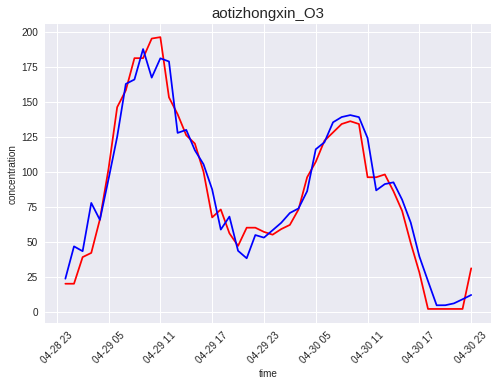

In [32]:
plt.title('aotizhongxin_O3',fontsize = 15)
plt.xticks(rotation = 45)
plt.xlabel('time',fontsize = 10)
plt.ylabel('concentration',fontsize = 10)
plt.plot(fix_station['O3'], 'r-')
plt.plot(fix_station['O3_c'], 'b-')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


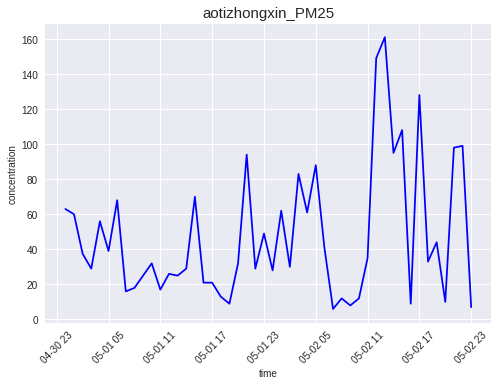

In [116]:
result = pd.Series(station_train['PM2.5'],name='PM25_c')
res_test = prediction_data.copy().reset_index()
result = pd.concat([res_test,result],axis=1)

fix_station = result[result['stationId'] == 'aotizhongxin_aq']
fix_station['utc_time'] = pd.to_datetime(fix_station['utc_time'])
fix_station = fix_station.set_index(['utc_time'])
plt.title('aotizhongxin_PM25',fontsize = 15)
plt.xticks(rotation = 45)
plt.xlabel('time',fontsize = 10)
plt.ylabel('concentration',fontsize = 10)
# plt.plot(fix_station['O3'], 'r-')
plt.plot(fix_station['PM25_c'], 'b-')

In [93]:
for i in range(48):
    pre_X_PM25['PM2.5_1'][248185+i] = prediction_new[248184+i]
    pre_X_PM25['O3_1'][248185+i] = prediction_new[248184+i]
    pre_X_PM25['PM10_1'][248185+i] = prediction_new[248184+i]
    pre_X_PM25['O3_2'][248185+i] = prediction_new[248183+i]
    pre_X_PM25['PM2.5_2'][248185+i] = prediction_new[248183+i]
    pre_X_PM25['PM10_2'][248185+i] = prediction_new[248183+i]
    pre_X_PM25['O3_1_diff'][248185+i] = pre_X_PM25['O3_1'][248185+i] - pre_X_PM25['O3_2'][248185+i]
    pre_X_PM25['PM10_1_diff'][248185+i] = pre_X_PM25['PM10_1'][248185+i] - pre_X_PM25['PM10_2'][248185+i]
    pre_X_PM25['PM2.5_1_diff'][248185+i] = pre_X_PM25['PM2.5_1'][248185+i] - pre_X_PM25['PM2.5_2'][248185+i]
    pre_X_PM25['PM2.5_24'][248185+i] = prediction_new[248161+i]
    pre_X_PM25['PM2.5_48'][248185+i] = prediction_new[248137+i]
    pre_X_PM25['PM2.5_24_mean'][248185+i] = sum(prediction_new['PM2.5'][248161+i: 248185+i]) / 24
    pre_X_PM25['PM2.5_48_mean'][248185+i] = sum(prediction_new['PM2.5'][248137+i: 248185+i]) / 48
    pre_X_PM25['PM2.5_48_max'][248185+i] = max(prediction_new['PM2.5'][248137+i: 248185+i])
    pre_X_PM25['PM2.5_24_max'][248185+i] = max(prediction_new['PM2.5'][248161+i: 248185+i])
    pre_X_PM25['PM2.5_48_min'][248185+i] = min(prediction_new['PM2.5'][248137+i: 248185+i])
    pre_X_PM25['PM2.5_24_min'][248185+i] = min(prediction_new['PM2.5'][248161+i: 248185+i])
    pre_X_PM25['PM2.5_48_std'][248185+i] = np.std(prediction_new['PM2.5'][248137+i: 248185+i])
    pre_X_PM25['PM2.5_24_std'][248185+i] = np.std(prediction_new['PM2.5'][248161+i: 248185+i])
    pre_X_PM25[1926+i] = lgb_PM25_model.predict(pre_X_PM25[1926+i:1927+i])

NameError: ignored

In [98]:
pre_X_PM25.columns

Index(['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity',
       'pressure', 'temperature', 'wind_direction', 'wind_speed', 'holiday',
       'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48', 'PM2.5_48_mean',
       'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max', 'PM2.5_48_std',
       'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min', 'PM2.5_2',
       'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1', 'PM10_2',
       'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff'],
      dtype='object')

In [204]:
final_prediction = pd.DataFrame()
for station in station_name:
  station_train = prediction_new[prediction_new['stationId'] == station].sort_values('utc_time').reset_index()
  del station_train['index']
  
  for i in range(48):
    station_train['PM2.5_1'][7091+i] = station_train['PM2.5'][7090+i]
    station_train['O3_1'][7091+i] = station_train['O3'][7090+i]
    station_train['PM10_1'][7091+i] = station_train['PM10'][7090+i]
    station_train['O3_2'][7091+i] = station_train['O3'][7089+i]
    station_train['PM2.5_2'][7091+i] = station_train['PM2.5'][7089+i]
    station_train['PM10_2'][7091+i] = station_train['PM10'][7089+i]
    station_train['O3_1_diff'][7091+i] = station_train['O3_1'][7091+i] - station_train['O3_2'][7091+i]
    station_train['PM10_1_diff'][7091+i] = station_train['PM10_1'][7091+i] - station_train['PM10_2'][7091+i]
    station_train['PM2.5_1_diff'][7091+i] = station_train['PM2.5_1'][7091+i] - station_train['PM2.5_2'][7091+i]
    station_train['PM2.5_24'][7091+i] = station_train['PM2.5'][7067+i]
    station_train['PM10_24'][7091+i] = station_train['PM10'][7067+i]
    station_train['O3_24'][7091+i] = station_train['O3'][7067+i]
    station_train['PM2.5_48'][7091+i] = station_train['PM2.5'][7043+i]
    station_train['PM10_48'][7091+i] = station_train['PM10'][7043+i]
    station_train['O3_48'][7091+i] = station_train['O3'][7043+i]
    
    station_train['PM2.5_24_mean'][7091+i] = sum(station_train['PM2.5'][7067+i: 7091+i]) / 24
    station_train['PM2.5_48_mean'][7091+i] = sum(station_train['PM2.5'][7043+i: 7091+i]) / 48
    station_train['PM2.5_48_max'][7091+i] = max(station_train['PM2.5'][7043+i: 7091+i])
    station_train['PM2.5_24_max'][7091+i] = max(station_train['PM2.5'][7067+i: 7091+i])
    station_train['PM2.5_48_min'][7091+i] = min(station_train['PM2.5'][7043+i: 7091+i])
    station_train['PM2.5_24_min'][7091+i] = min(station_train['PM2.5'][7067+i: 7091+i])
    station_train['PM2.5_48_std'][7091+i] = np.std(station_train['PM2.5'][7043+i: 7091+i])
    station_train['PM2.5_24_std'][7091+i] = np.std(station_train['PM2.5'][7067+i: 7091+i])
    
    station_train['PM10_24_mean'][7091+i] = sum(station_train['PM10'][7067+i: 7091+i]) / 24
    station_train['PM10_48_mean'][7091+i] = sum(station_train['PM10'][7043+i: 7091+i]) / 48
    station_train['PM10_48_max'][7091+i] = max(station_train['PM10'][7043+i: 7091+i])
    station_train['PM10_24_max'][7091+i] = max(station_train['PM10'][7067+i: 7091+i])
    station_train['PM10_48_min'][7091+i] = min(station_train['PM10'][7043+i: 7091+i])
    station_train['PM10_24_min'][7091+i] = min(station_train['PM10'][7067+i: 7091+i])
    station_train['PM10_48_std'][7091+i] = np.std(station_train['PM10'][7043+i: 7091+i])
    station_train['PM10_24_std'][7091+i] = np.std(station_train['PM10'][7067+i: 7091+i])
    
    station_train['O3_24_mean'][7091+i] = sum(station_train['O3'][7067+i: 7091+i]) / 24
    station_train['O3_48_mean'][7091+i] = sum(station_train['O3'][7043+i: 7091+i]) / 48
    station_train['O3_48_max'][7091+i] = max(station_train['O3'][7043+i: 7091+i])
    station_train['O3_24_max'][7091+i] = max(station_train['O3'][7067+i: 7091+i])
    station_train['O3_48_min'][7091+i] = min(station_train['O3'][7043+i: 7091+i])
    station_train['O3_24_min'][7091+i] = min(station_train['O3'][7067+i: 7091+i])
    station_train['O3_48_std'][7091+i] = np.std(station_train['O3'][7043+i: 7091+i])
    station_train['O3_24_std'][7091+i] = np.std(station_train['O3'][7067+i: 7091+i])
    
    station_train['PM2.5'][7091+i] = (lgb_PM25_model_0.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
       'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
       'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
       'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1',
       'PM10_2', 'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]) + lgb_PM25_model_1.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
       'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
       'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
       'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1',
       'PM10_2', 'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]) + lgb_PM25_model_2.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
       'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
       'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
       'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1',
       'PM10_2', 'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]) + lgb_PM25_model_3.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
       'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
       'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
       'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1',
       'PM10_2', 'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']]) + lgb_PM25_model_4.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
       'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
       'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
       'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1',
       'PM10_2', 'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']])) / 5

    
    station_train['PM10'][7091+i] = (lgb_PM10_model_0.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_2',
       'O3_1_diff']]) + lgb_PM10_model_1.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_2',
       'O3_1_diff']]) + lgb_PM10_model_2.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_2',
       'O3_1_diff']]) + lgb_PM10_model_3.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_2',
       'O3_1_diff']]) + lgb_PM10_model_4.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_2',
       'O3_1_diff']])) / 5
    
    station_train['O3'][7091+i] = (lgb_O3_model_0.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]) + lgb_O3_model_1.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]) + lgb_O3_model_2.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]) + lgb_O3_model_3.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']]) + lgb_O3_model_4.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
                 'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
       'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']])) / 5
    
  final_prediction = pd.concat([final_prediction, station_train], axis=0)
    
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on 

In [0]:
station_train = prediction_new[prediction_new['stationId'] == 'zhiwuyuan_aq'].sort_values('utc_time').reset_index()
del station_train['index']

In [109]:
station_train[7091:]

,O3,PM10,PM2.5,humidity,pressure,stationId,temperature,utc_time,wind_direction,wind_speed,...,O3_24_max,O3_48_std,O3_24_std,O3_48_min,O3_24_min,O3_2,O3_1_diff,O3_3,O3_12,O3_8
7091,NaN,NaN,NaN,33.75,1000.725325,zhiwuyuan_aq,19.000,2018-05-01 00:00:00,13.2450,12.0225,...,124.267541,23.036932,23.775082,49.747964,49.747964,74.157838,9.998439,57.707688,93.019501,71.556270
7092,NaN,NaN,NaN,28.75,1000.208575,zhiwuyuan_aq,20.500,2018-05-01 01:00:00,24.1025,14.0050,...,NaN,NaN,NaN,NaN,NaN,84.156276,NaN,74.157838,49.747964,63.833614
7093,NaN,NaN,NaN,25.25,1000.737375,zhiwuyuan_aq,21.000,2018-05-01 02:00:00,33.2500,16.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.156276,78.515250,53.690975
7094,NaN,NaN,NaN,22.50,1000.606450,zhiwuyuan_aq,21.500,2018-05-01 03:00:00,37.6050,17.2250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.510277,60.893632
7095,NaN,NaN,NaN,20.25,999.737700,zhiwuyuan_aq,23.000,2018-05-01 04:00:00,42.6875,17.1250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.556270,63.908903
7096,NaN,NaN,NaN,20.25,998.086000,zhiwuyuan_aq,23.500,2018-05-01 05:00:00,46.0225,16.6200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.833614,57.707688
7097,NaN,NaN,NaN,21.00,999.657725,zhiwuyuan_aq,23.500,2018-05-01 06:00:00,47.2400,15.2950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.690975,74.157838
7098,NaN,NaN,NaN,22.25,999.622000,zhiwuyuan_aq,22.250,2018-05-01 07:00:00,46.1625,12.0125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.893632,84.156276
7099,NaN,NaN,NaN,24.50,999.235925,zhiwuyuan_aq,21.000,2018-05-01 08:00:00,41.9650,8.3075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.908903,NaN
7100,NaN,NaN,NaN,26.75,1000.009900,zhiwuyuan_aq,20.000,2018-05-01 09:00:00,37.8625,5.9550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.707688,NaN


In [113]:
station_train = prediction_new[prediction_new['stationId'] == 'aotizhongxin_aq'].sort_values('utc_time').reset_index()
del station_train['index']

for i in range(48):
  station_train['PM2.5_1'][7091+i] = station_train['PM2.5'][7090+i]
  station_train['O3_1'][7091+i] = station_train['O3'][7090+i]
  station_train['PM10_1'][7091+i] = station_train['PM10'][7090+i]
  
  station_train['O3_2'][7091+i] = station_train['O3'][7089+i]
  station_train['PM2.5_2'][7091+i] = station_train['PM2.5'][7089+i]
  station_train['PM10_2'][7091+i] = station_train['PM10'][7089+i]
  
  station_train['O3_1_diff'][7091+i] = station_train['O3_1'][7091+i] - station_train['O3_2'][7091+i]
  station_train['PM10_1_diff'][7091+i] = station_train['PM10_1'][7091+i] - station_train['PM10_2'][7091+i]
  station_train['PM2.5_1_diff'][7091+i] = station_train['PM2.5_1'][7091+i] - station_train['PM2.5_2'][7091+i]
  
  station_train['PM2.5_24'][7091+i] = station_train['PM2.5'][7067+i]
  station_train['PM10_24'][7091+i] = station_train['PM10'][7067+i]
  station_train['O3_24'][7091+i] = station_train['O3'][7067+i]
  
  station_train['PM2.5_48'][7091+i] = station_train['PM2.5'][7043+i]
  station_train['PM10_48'][7091+i] = station_train['PM10'][7043+i]
  station_train['O3_48'][7091+i] = station_train['O3'][7043+i]

  station_train['PM2.5_24_mean'][7091+i] = sum(station_train['PM2.5'][7067+i: 7091+i]) / 24
  station_train['PM2.5_48_mean'][7091+i] = sum(station_train['PM2.5'][7043+i: 7091+i]) / 48
  station_train['PM2.5_48_max'][7091+i] = max(station_train['PM2.5'][7043+i: 7091+i])
  station_train['PM2.5_24_max'][7091+i] = max(station_train['PM2.5'][7067+i: 7091+i])
  station_train['PM2.5_48_min'][7091+i] = min(station_train['PM2.5'][7043+i: 7091+i])
  station_train['PM2.5_24_min'][7091+i] = min(station_train['PM2.5'][7067+i: 7091+i])
  station_train['PM2.5_48_std'][7091+i] = np.std(station_train['PM2.5'][7043+i: 7091+i])
  station_train['PM2.5_24_std'][7091+i] = np.std(station_train['PM2.5'][7067+i: 7091+i])

  station_train['PM10_24_mean'][7091+i] = sum(station_train['PM10'][7067+i: 7091+i]) / 24
  station_train['PM10_48_mean'][7091+i] = sum(station_train['PM10'][7043+i: 7091+i]) / 48
  station_train['PM10_48_max'][7091+i] = max(station_train['PM10'][7043+i: 7091+i])
  station_train['PM10_24_max'][7091+i] = max(station_train['PM10'][7067+i: 7091+i])
  station_train['PM10_48_min'][7091+i] = min(station_train['PM10'][7043+i: 7091+i])
  station_train['PM10_24_min'][7091+i] = min(station_train['PM10'][7067+i: 7091+i])
  station_train['PM10_48_std'][7091+i] = np.std(station_train['PM10'][7043+i: 7091+i])
  station_train['PM10_24_std'][7091+i] = np.std(station_train['PM10'][7067+i: 7091+i])

  station_train['O3_24_mean'][7091+i] = sum(station_train['O3'][7067+i: 7091+i]) / 24
  station_train['O3_48_mean'][7091+i] = sum(station_train['O3'][7043+i: 7091+i]) / 48
  station_train['O3_48_max'][7091+i] = max(station_train['O3'][7043+i: 7091+i])
  station_train['O3_24_max'][7091+i] = max(station_train['O3'][7067+i: 7091+i])
  station_train['O3_48_min'][7091+i] = min(station_train['O3'][7043+i: 7091+i])
  station_train['O3_24_min'][7091+i] = min(station_train['O3'][7067+i: 7091+i])
  station_train['O3_48_std'][7091+i] = np.std(station_train['O3'][7043+i: 7091+i])
  station_train['O3_24_std'][7091+i] = np.std(station_train['O3'][7067+i: 7091+i])

  station_train['PM2.5'][7091+i] = lgb_PM25_model.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
               'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
     'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
     'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
     'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1', 'PM10_2', 'PM10_1_diff', 'O3_1', 'O3_2', 'O3_1_diff']])

  station_train['PM10'][7091+i] = lgb_PM10_model.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
               'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_2', 'PM2.5_1_diff', 'PM10_1',
     'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
     'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
     'PM10_24_min', 'PM10_2', 'PM10_1_diff',
     'O3_1', 'O3_2',
     'O3_1_diff']])

  station_train['O3'][7091+i] = lgb_O3_model.predict(station_train[7091+i:7092+i][['longitude', 'latitude', 'year', 'month', 'day', 'hour', 'humidity','pressure',
               'temperature', 'wind_direction', 'wind_speed', 'holiday', 'dayofweek', 'PM2.5_1',
     'PM2.5_2', 'PM2.5_1_diff', 'PM10_1', 'PM10_2', 'PM10_1_diff',
     'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
     'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
     'O3_1_diff', 'O3_3', 'O3_12', 'O3_8']])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [112]:
station_train.columns

Index(['O3', 'PM10', 'PM2.5', 'humidity', 'pressure', 'stationId',
       'temperature', 'utc_time', 'wind_direction', 'wind_speed', 'longitude',
       'latitude', 'local_time', 'year', 'month', 'day', 'hour', 'date',
       'holiday', 'dayofweek', 'PM2.5_1', 'PM2.5_24', 'PM2.5_48',
       'PM2.5_48_mean', 'PM2.5_24_mean', 'PM2.5_48_max', 'PM2.5_24_max',
       'PM2.5_48_std', 'PM2.5_24_std', 'PM2.5_48_min', 'PM2.5_24_min',
       'PM2.5_2', 'PM2.5_1_diff', 'PM2.5_3', 'PM2.5_12', 'PM2.5_8', 'PM10_1',
       'PM10_24', 'PM10_48', 'PM10_48_mean', 'PM10_24_mean', 'PM10_48_max',
       'PM10_24_max', 'PM10_48_std', 'PM10_24_std', 'PM10_48_min',
       'PM10_24_min', 'PM10_2', 'PM10_1_diff', 'PM10_3', 'PM10_12', 'PM10_8',
       'O3_1', 'O3_24', 'O3_48', 'O3_48_mean', 'O3_24_mean', 'O3_48_max',
       'O3_24_max', 'O3_48_std', 'O3_24_std', 'O3_48_min', 'O3_24_min', 'O3_2',
       'O3_1_diff', 'O3_3', 'O3_12', 'O3_8'],
      dtype='object')

In [114]:
station_train

,O3,PM10,PM2.5,humidity,pressure,stationId,temperature,utc_time,wind_direction,wind_speed,...,O3_24_max,O3_48_std,O3_24_std,O3_48_min,O3_24_min,O3_2,O3_1_diff,O3_3,O3_12,O3_8
0,214.000000,50.898794,63.000000,56.7600,990.815000,aotizhongxin_aq,27.2225,2017-07-09 13:00:00,190.8400,6.5675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,179.000000,68.000000,62.000000,64.4100,991.247500,aotizhongxin_aq,26.5650,2017-07-09 14:00:00,166.8825,4.6950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,152.000000,-15.045633,23.000000,72.0550,991.680000,aotizhongxin_aq,25.9075,2017-07-09 15:00:00,120.7425,4.5600,...,NaN,NaN,NaN,NaN,NaN,214.000000,-35.000000,NaN,NaN,NaN
3,140.000000,-22.377722,18.000000,72.8325,991.427500,aotizhongxin_aq,25.7100,2017-07-09 16:00:00,68.0950,2.4400,...,NaN,NaN,NaN,NaN,NaN,179.000000,-27.000000,214.000000,NaN,NaN
4,124.000000,-25.741962,11.000000,73.6100,991.170000,aotizhongxin_aq,25.5125,2017-07-09 17:00:00,182.9550,4.2450,...,NaN,NaN,NaN,NaN,NaN,152.000000,-12.000000,179.000000,NaN,NaN
5,109.000000,22.000000,12.000000,74.3925,990.917500,aotizhongxin_aq,25.3150,2017-07-09 18:00:00,348.4350,7.6150,...,NaN,NaN,NaN,NaN,NaN,140.000000,-16.000000,152.000000,NaN,NaN
6,95.000000,34.000000,16.000000,79.9450,991.075000,aotizhongxin_aq,24.7900,2017-07-09 19:00:00,260.7625,6.6950,...,NaN,NaN,NaN,NaN,NaN,124.000000,-15.000000,140.000000,NaN,NaN
7,59.779736,58.000000,21.000000,85.5050,991.235000,aotizhongxin_aq,24.1600,2017-07-09 20:00:00,263.7625,5.7950,...,NaN,NaN,NaN,NaN,NaN,109.000000,-14.000000,124.000000,NaN,NaN
8,33.000000,40.000000,27.000000,91.0600,991.395000,aotizhongxin_aq,23.5125,2017-07-09 21:00:00,267.6975,4.9275,...,NaN,NaN,NaN,NaN,NaN,95.000000,-35.220264,109.000000,NaN,214.000000
9,38.000000,45.000000,28.000000,79.6075,991.520000,aotizhongxin_aq,25.3350,2017-07-09 22:00:00,346.7150,5.5525,...,NaN,NaN,NaN,NaN,NaN,59.779736,-26.779736,95.000000,NaN,179.000000


In [207]:
final_result = final_prediction.sort_values('utc_time').reset_index()
del final_result['index']

final_result

,O3,PM10,PM2.5,humidity,pressure,stationId,temperature,utc_time,wind_direction,wind_speed,...,O3_24_max,O3_48_std,O3_24_std,O3_48_min,O3_24_min,O3_2,O3_1_diff,O3_3,O3_12,O3_8
0,214.000000,50.898794,63.000000,56.7600,990.815000,aotizhongxin_aq,27.2225,2017-07-09 13:00:00,190.8400,6.5675,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,192.000000,143.000000,72.000000,60.3950,993.827500,tongzhou_aq,27.5975,2017-07-09 13:00:00,161.5575,11.1550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,199.000000,113.000000,59.000000,55.1375,992.715000,daxing_aq,28.0275,2017-07-09 13:00:00,183.7500,8.1825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,72.000000,83.000000,56.000000,54.3125,993.305000,yufa_aq,28.1550,2017-07-09 13:00:00,182.3775,5.5850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.000000,263.092184,153.000000,54.6575,980.360000,donggaocun_aq,28.1275,2017-07-09 13:00:00,164.1625,10.1825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,246.000000,120.000000,81.000000,64.0675,967.460000,mentougou_aq,26.1325,2017-07-09 13:00:00,233.8900,7.1100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,189.000000,78.528566,71.000000,56.0750,991.002500,qianmen_aq,27.4875,2017-07-09 13:00:00,193.4550,6.8850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,170.000000,177.000000,99.000000,57.8450,992.807500,shunyi_aq,26.1650,2017-07-09 13:00:00,160.5775,6.3200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,63.006685,204.096019,128.444027,54.9025,987.680000,liulihe_aq,27.7000,2017-07-09 13:00:00,272.9325,5.0450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,176.000000,158.000000,93.000000,58.8850,979.912500,yungang_aq,27.0150,2017-07-09 13:00:00,231.5950,6.8075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
final_result[248185:].to_csv('drive/final_result_1.csv')

In [0]:
result = final_result[248185:]

In [0]:
final_result.to_csv('drive/final_result_all.csv')

In [1]:
# result_PM25 = pd.Series(result['PM2.5'],name='PM25_c')
# res_test = prediction_data.copy().reset_index()
# result = pd.concat([res_test,result],axis=1)

fix_station = result[result['stationId'] == 'aotizhongxin_aq']
fix_station['local_time'] = pd.to_datetime(fix_station['local_time'])
fix_station = fix_station.set_index(['local_time'])
plt.title('aotizhongxin_O3',fontsize = 15)
plt.xticks(rotation = 45)
plt.xlabel('time',fontsize = 10)
plt.ylabel('concentration',fontsize = 10)
# plt.plot(fix_station['O3'], 'r-')
plt.plot(fix_station['O3'], 'b-')

NameError: ignored

In [0]:
result_format = pd.read_csv('drive/final_result_1.csv')

In [14]:
result_format = pd.read_csv('drive/final_result_1.csv')
result_format.rename(columns={'stationId': 'test_id'}, inplace=True)


result_format = result_format.sort_values(by=['test_id', 'local_time']).reset_index()
del result_format['index']
# result_format = result_format[['test_id', 'PM2.5', 'PM10', 'O3']]

frame = result_format[['test_id', 'hour']].apply(
    lambda x: x.test_id +'#'+str(x.hour), axis=1)
t = pd.concat([result_format, frame], axis=1)

t

,Unnamed: 0,O3,PM10,PM2.5,humidity,pressure,test_id,temperature,utc_time,wind_direction,...,O3_48_std,O3_24_std,O3_48_min,O3_24_min,O3_2,O3_1_diff,O3_3,O3_12,O3_8,0
0,248185,53.750796,230.915390,72.478330,36.25,1008.698525,aotizhongxin_aq,19.250,2018-05-01 00:00:00,16.7850,...,53.345352,45.789070,2.000000,2.000000,2.000000,29.000000,2.0,96.0,49.0,aotizhongxin_aq#0
1,248248,72.775901,200.288391,65.580854,31.25,1008.631125,aotizhongxin_aq,20.750,2018-05-01 01:00:00,24.7325,...,52.702992,45.806419,2.000000,2.000000,31.000000,22.750796,2.0,98.0,28.0,aotizhongxin_aq#1
2,248266,88.088125,180.452955,59.065879,26.75,1008.819050,aotizhongxin_aq,21.250,2018-05-01 02:00:00,30.6150,...,51.865409,45.756096,2.000000,2.000000,53.750796,19.025105,31.0,86.0,2.0,aotizhongxin_aq#2
3,248307,103.816672,164.304360,50.805108,24.00,1009.149025,aotizhongxin_aq,21.000,2018-05-01 03:00:00,33.2825,...,51.395290,45.858419,2.000000,2.000000,72.775901,15.312224,NaN,72.0,2.0,aotizhongxin_aq#3
4,248338,117.051853,150.176732,44.683942,20.25,1008.308600,aotizhongxin_aq,22.500,2018-05-01 04:00:00,38.3700,...,51.004777,46.317854,2.000000,2.000000,88.088125,15.728547,NaN,49.0,2.0,aotizhongxin_aq#4
5,248365,128.046533,139.920208,40.174454,20.75,1007.379200,aotizhongxin_aq,22.750,2018-05-01 05:00:00,40.9300,...,51.044725,46.948503,2.000000,2.000000,103.816672,13.235181,NaN,28.0,2.0,aotizhongxin_aq#5
6,248427,134.543473,129.652972,36.771153,21.50,1007.492475,aotizhongxin_aq,22.500,2018-05-01 06:00:00,40.8850,...,51.305685,47.756834,2.000000,2.000000,117.051853,10.994680,NaN,2.0,2.0,aotizhongxin_aq#6
7,248458,141.307920,122.415838,35.325219,22.25,1007.728950,aotizhongxin_aq,21.250,2018-05-01 07:00:00,38.6650,...,51.073920,48.340912,2.000000,2.000000,128.046533,6.496939,NaN,2.0,31.0,aotizhongxin_aq#7
8,248466,144.454763,113.789682,35.940571,24.00,1007.536325,aotizhongxin_aq,20.750,2018-05-01 08:00:00,35.9075,...,50.667983,49.019115,2.000000,2.000000,134.543473,6.764447,NaN,2.0,NaN,aotizhongxin_aq#8
9,248501,141.024331,109.738826,36.272321,25.50,1007.974000,aotizhongxin_aq,18.750,2018-05-01 09:00:00,39.7925,...,49.558751,49.581248,2.000000,2.000000,141.307920,3.146843,NaN,2.0,NaN,aotizhongxin_aq#9


In [19]:
result_submission = result_format[['stationId','day','hour','PM2.5','PM10','O3']]
station_dic = {}
station_dic_reverse = {}
station_sbumission_list = ['dongsi_aq','tiantan_aq','guanyuan_aq','wanshouxigong_aq','aotizhongxin_aq','nongzhanguan_aq','wanliu_aq','beibuxinqu_aq',
               'zhiwuyuan_aq','fengtaihuayuan_aq','yungang_aq','gucheng_aq','fangshan_aq','daxing_aq','yizhuang_aq','tongzhou_aq',
                'shunyi_aq','pingchang_aq','mentougou_aq','pinggu_aq','huairou_aq','miyun_aq','yanqin_aq','dingling_aq','badaling_aq',
               'miyunshuiku_aq','donggaocun_aq','yongledian_aq','yufa_aq','liulihe_aq','qianmen_aq','yongdingmennei_aq','xizhimenbei_aq',
               'nansanhuan_aq','dongsihuan_aq']
for i in range(len(station_sbumission_list)):
    station_dic[station_sbumission_list[i]] = i
    station_dic_reverse[i] = station_sbumission_list[i]
result_submission['stationId'] = result_submission['stationId'].apply(lambda x: station_dic[x])

def rep_hour(day,hour):
    if day > 1:
        hour += 24
    return hour

result_submission['hour'] = result_submission.apply(lambda row: rep_hour(row['day'],row['hour']),axis = 1)
result_submission['hour'] = result_submission['hour'].astype(int)
final_res_sub = result_submission.sort_values(by = ['stationId','hour'])
final_res_sub['stationId'] = final_res_sub['stationId'].apply(lambda x: station_dic_reverse[x])

def rep_id(station_id,hour):
    hour = str(int(hour))
    res = station_id + '#' + hour
    return res

final_res_sub['stationId'] = final_res_sub.apply(lambda row: rep_id(row['stationId'],row['hour']),axis = 1)
final_res_sub = final_res_sub.reset_index()
final_res_sub.drop(['index','day','hour'],axis = 1,inplace=True)
final_res_sub.columns = ['test_id','PM2.5','PM10','O3']
final_res_sub.to_csv('drive/submission.csv',index = None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing